# (1m)Noise

author: laquitainesteeve@gmail.com

Purpose: describe trace background noise

Execution time: 2 min

## Setup

Create and activate virtual environment kernel `demo` from (envs/demo.yml)

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import packages
import os
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface as si
from matplotlib import pyplot as plt;
import multiprocessing
import torch
import pandas as pd
import seaborn as sns
import matplotlib
print("spikeinterface version:", si.__version__)

# dandiset parameters
dandiset_id = '001250'
filepath_evoked = 'sub-demo-npx-bio-evoked/sub-demo-npx-bio-evoked_ecephys.nwb'
filepath_spont = 'sub-demo-npx-bio-spont/sub-demo-npx-bio-spont_ecephys.nwb'

# project path
proj_path = "/Users/steeve_laquitaine/Desktop/EPFL/2022_2024_bbp/spikebias/"
# proj_path = "/home/jovyan/steevelaquitaine/spikebias/"
os.chdir(proj_path)

from src.nodes.utils import get_config, get_stats_config, standardize_layers
from src.nodes.validation import noise

# evoked demo
cfg_e, param_cfg_e = get_config("silico_neuropixels", "npx_evoked").values() # config
FREQ_MIN_E = param_cfg_e["run"]["preprocessing"]["min_filter_freq"] # preprocessing parameters
FREQ_MAX_E = param_cfg_e["run"]["preprocessing"]["max_filter_freq"]

# spontaneous demo
cfg_s, param_cfg_s = get_config("silico_neuropixels", "npx_spont").values() # config
FREQ_MIN_S = param_cfg_s["run"]["preprocessing"]["min_filter_freq"] # preprocessing parameters
FREQ_MAX_S = param_cfg_s["run"]["preprocessing"]["max_filter_freq"]

# parameters
LAYERS = ['L5', 'L6']

# FIGURE SETTINGS
FIG_SIZE = (1.8, 1.6)
COLOR_SILI = np.array([228, 26, 28]) / 255
COLOR_NE = [1, 0.49, 0]

# experiment colors
cl = dict()
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NE"] = [1, 0.49, 0] # orange

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
2025-04-06 09:04:21,835 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-06 09:04:21,904 - root - utils.py - get_config - INFO - Reading experiment config. - done
2025-04-06 09:04:21,906 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-06 09:04:21,947 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 8
available gpus: False


['/bin/bash: free: command not found']

## Load demos

In [ ]:
%%time

# EVOKED DEMO

with DandiAPIClient() as client: # download the extractors from Dandi archive
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath_evoked)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
RecordingE = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile") # get extractor
RecordingE = spre.astype(RecordingE, "int16") # compress to int16 (like kilosorts)
RecordingE = spre.bandpass_filter(RecordingE, freq_min=FREQ_MIN_E, freq_max=FREQ_MAX_E)  # band-pass filter
RecordingE = spre.common_reference(RecordingE, reference="global", operator="median") # common reference
traces_ne = RecordingE.get_traces() # get trace array

# SPONTANEOUS DEMO

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath_spont)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
RecordingS = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile")
RecordingS = spre.astype(RecordingS, "int16")
RecordingS = spre.bandpass_filter(RecordingS, freq_min=FREQ_MIN_S, freq_max=FREQ_MAX_S)
RecordingS = spre.common_reference(RecordingS, reference="global", operator="median")
traces_ns = RecordingS.get_traces()

## Compute

In [ ]:
%%time 

# compute noise
traces = RecordingS.get_traces() # spontaneous
noise_s = noise.get_in_parallel_single_ns(traces)
traces = RecordingE.get_traces() # evoked
noise_e = noise.get_in_parallel_single_ne(traces)

# - get site layers
lyr_s = RecordingS.get_property("layers")
lyr_e = RecordingE.get_property("layers")

# format dataset
# - group l2 and l3
# spont.
lyr_s = standardize_layers(lyr_s)
in_ctx = np.isin(lyr_s, LAYERS)
s_data = pd.DataFrame(data=np.array(noise_s[in_ctx]), columns=["noise"])
lyr_s = np.array(lyr_s)[in_ctx]
s_data["layer"] = lyr_s
s_data["experiment"] = "Biophy. spont."
s_data = s_data.sort_values(by=["layer"])

# evoked
lyr_e = standardize_layers(lyr_e)
in_ctx = np.isin(lyr_e, LAYERS)
e_data = pd.DataFrame(data=np.array(noise_e[in_ctx]), columns=["noise"])
lyr_e = np.array(lyr_e)[in_ctx]
e_data["layer"] = lyr_e
e_data["experiment"] = "Biophy. evoked"
e_data = e_data.sort_values(by=["layer"])

# concatenate
plot_data = pd.concat([s_data, e_data], ignore_index=True)

# drop sites outside cortex
mask = np.isin(plot_data["layer"], LAYERS)
plot_data = plot_data[mask]
plot_data = plot_data.sort_values(by=["layer"])

# unit-test
assert s_data["layer"].unique().tolist() == LAYERS, "wrong layers"
assert e_data["layer"].unique().tolist() == LAYERS, "wrong layers"

#### Plot

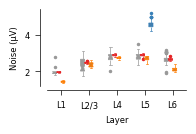

In [ ]:
FIG_SIZE = (1.8, 1)

# setup plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot
ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="noise",
    hue="experiment",
    notch=True,
    hue_order=[
        "Biophy. spont.",
        "Biophy. evoked",
    ],
    palette=[cl["COLOR_NS"], cl["COLOR_NE"]],
    width=0.6,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

ax.set_ylabel("Noise (\u03bcV)")
ax.set_xlabel("Layer")

## Statistical tests

### Noise changes across layers?

In [ ]:
def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.experiment==exp) & (plot_data.layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record

# 1. kruskall-wallis
# 2. perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
# 3. medians and ci95
noise.get_kk_demo(plot_data, "Biophy. spont.")
noise.get_posthoc_dunn_holm_sidak_demo(plot_data, "Biophy. spont.")
m_ns = get_medians_and_ci95(plot_data, "Biophy. spont.", "noise") 

noise.get_kk_demo(plot_data, "Biophy. evoked")
noise.get_posthoc_dunn_holm_sidak_demo(plot_data, "Biophy. evoked")
m_e = get_medians_and_ci95(plot_data, "Biophy. evoked", "noise") 


--------------------MS--------------------

H=62.47102557681285, p=8.768468370671957e-13
N_L1 = 10 sites
N_L23 = 42 sites
N_L4 = 34 sites
N_L5 = 42 sites
N_L6 = 98 sites
1.9311 $\pm$ 0.171132, 2.189 $\pm$ 0.116526, 2.8097 $\pm$ 0.086615, 2.8482 $\pm$ 0.070086, 2.6354 $\pm$ 0.038763, 

--------------------NS--------------------

H=178.66644908122998, p=1.441853196249705e-37
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites
1.9628 $\pm$ 0.015682, 2.4645 $\pm$ 0.010906, 2.9039 $\pm$ 0.024573, 2.9261 $\pm$ 0.018631, 2.6722 $\pm$ 0.01622, 

--------------------E--------------------

H=171.6940162304055, p=4.527651062676017e-36
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites
1.4329 $\pm$ 0.021381, 2.3516 $\pm$ 0.038406, 2.741 $\pm$ 0.02469, 2.752 $\pm$ 0.033949, 2.1149 $\pm$ 0.024723, 


## Are models noise the same?

Kruskall wallis and posthoc

In [ ]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["experiment"] == exp) & (df["layer"] == layer)])


def get_noise(df, exp, layer):
    return df[(df["experiment"] == exp) & (df["layer"] == layer)]["noise"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_noise(df, "Biophy. spont.", layer),
        get_noise(df, "Biophy. evoked", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_E = {count_sites(df, "Biophy. evoked", layer)} sites""")
    print(f"""N_M = {count_sites(df, "npx (Marques-Smith)", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_noise(plot_data, "Biophy. spont.", layer),
        get_noise(plot_data, "Biophy. evoked", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["Biophy. spont.", "Biophy. evoked"]
    df.index = ["Biophy. spont.", "Biophy. evoked"]
    return df


def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_noise(plot_data, "Biophy. spont.", layer),
        get_noise(plot_data, "Biophy. evoked", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["Biophy. spont.", "Biophy. evoked"]
    df.index = ["Biophy. spont.", "Biophy. evoked"]
    return df

In [ ]:
print("\n------LAYER 5:------\n")
get_kk_compare_exps(plot_data, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, "L5"))

print("\n------LAYER 6:------\n")
get_kk_compare_exps(plot_data, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L6"))

------LAYER 1:------

H=29.234883720930213, p=4.4846201140856504e-07
N_NS = 16 sites
N_E = 16 sites
N_M = 10 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000,0.645494,0.000148
Biophy. spont.,0.645494,1.000000,0.000001
Biophy. evoked,0.000148,0.000001,1.000000



------LAYER 2/3:------

H=13.327628317983567, p=0.0012762691815353707
N_NS = 47 sites
N_E = 47 sites
N_M = 42 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000,0.002465,0.599581
Biophy. spont.,0.002465,1.000000,0.007381
Biophy. evoked,0.599581,0.007381,1.000000



------LAYER 4:------

H=14.371799765327893, p=0.0007571873215229637
N_NS = 19 sites
N_E = 19 sites
N_M = 34 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000,0.016231,0.112727
Biophy. spont.,0.016231,1.000000,0.000561
Biophy. evoked,0.112727,0.000561,1.000000



------LAYER 5:------

H=44.68570721981405, p=1.979802950953219e-10
N_NS = 52 sites
N_E = 52 sites
N_M = 42 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked,Synth. (Buccino)
npx (Marques-Smith),1.000000e+00,6.170891e-01,6.170891e-01,8.708621e-26
Biophy. spont.,6.170891e-01,1.000000e+00,1.823141e-01,4.083836e-25
Biophy. evoked,6.170891e-01,1.823141e-01,1.000000e+00,1.730862e-37
Synth. (Buccino),8.708621e-26,4.083836e-25,1.730862e-37,1.000000e+00



------LAYER 6:------

H=138.3650527968963, p=9.003482837003048e-31
N_NS = 68 sites
N_E = 68 sites
N_M = 98 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000e+00,2.890727e-01,2.301698e-24
Biophy. spont.,2.890727e-01,1.000000e+00,6.616927e-25
Biophy. evoked,2.301698e-24,6.616927e-25,1.000000e+00


## Are models noise the same?

Mann-Whitney U test

In [ ]:
print("\nlayer 5\n")
noise.get_mwu(plot_data, "Biophy. evoked", "Biophy. spont.", "L5")

print("\nlayer 6\n")
noise.get_mwu(plot_data, "Biophy. evoked", "Biophy. spont.", "L6")


layer 1

1 vs. 2, z=66.0, p=0.48379408987835437, N_1=10, N_2=16

layer 2/3

1 vs. 2, z=719.0, p=0.02741632075746762, N_1=42, N_2=47

layer 4

1 vs. 2, z=227.0, p=0.07638507627249845, N_1=34, N_2=19

layer 5

1 vs. 2, z=768.0, p=0.0134009597257908, N_1=42, N_2=52
1 vs. 2, z=0.0, p=8.341564166878022e-59, N_1=42, N_2=384

layer 6

1 vs. 2, z=2933.0, p=0.19122888444827751, N_1=98, N_2=68
